In [7]:
!wget -nc "https://raw.githubusercontent.com/sashiko-345/eva/master/dog.jpg"
!wget -nc "https://raw.githubusercontent.com/sashiko-345/eva/master/eva/udfs/camera_trap_animal_detector.py"

File ‘dog.jpg’ already there; not retrieving.

--2022-10-28 17:05:57--  https://raw.githubusercontent.com/sashiko-345/eva/master/eva/udfs/camera_trap_animal_detector.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9932 (9.7K) [text/plain]
Saving to: ‘camera_trap_animal_detector.py’

camera_trap_animal_ 100%[===================>]   9.70K  --.-KB/s    in 0s      

2022-10-28 17:05:57 (25.5 MB/s) - ‘camera_trap_animal_detector.py’ saved [9932/9932]



In [10]:
# first run "eva_server" in terminal with you python venv(i.e. test_eva_db you just created)

# run this ipynb under the same python venv as that of server

# connect to server
from eva.server.db_api import connect
import nest_asyncio
nest_asyncio.apply()
connection = connect(host = '127.0.0.1', port = 5435)
cursor = connection.cursor()

In [8]:
# load
cursor.execute('LOAD FILE "dog.jpg" INTO singlePic;')
response = cursor.fetch_all()
print(response)

@status: -1
@batch: None
@error: Failed to find a video file at location: dog.jpg


In [27]:
drop_udf_query = """DROP UDF AnimalDetector;
        """
cursor.execute(drop_udf_query)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                          0
0  UDF AnimalDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.01135491100001218


In [28]:
import os
udf_path = os.getcwd()
udf_path += '/camera_trap_animal_detector.py'
create_udf_query = f"""CREATE UDF IF NOT EXISTS AnimalDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (labels NDARRAY STR(ANYDIM),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  Classification
                  IMPL  '{udf_path}';
        """
# load
cursor.execute(create_udf_query)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF AnimalDetector successfully added to the d...
@batch_size: 1
@identifier_column: None
@query_time: 1.3821024490000013


In [10]:
# query dog
cursor.execute('''SELECT id, data FROM singlePic1''')
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:    singlepic1.id                                    singlepic1.data
0              0  [[[101, 165, 162], [96, 160, 157], [93, 156, 1...
1              0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
@batch_size: 2
@identifier_column: None
@query_time: 0.1631846239999959


In [29]:
# query dog with animal detector
cursor.execute('''SELECT id, AnimalDetector(data) FROM singlePic1 where id < 1''')
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:    singlepic1.id animaldetector.labels               animaldetector.scores
0              0    [blank, non_blank]      [[[1.363993674e-23]], [[1.0]]]
1              0    [blank, non_blank]  [[[0.898337841]], [[0.101662159]]]
@batch_size: 2
@identifier_column: None
@query_time: 18.714315225999997


In [4]:
# visualize the output
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['fastrcnnobjectdetector.bboxes', 'fastrcnnobjectdetector.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(img)

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(img)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

OpenCV: FFMPEG: tag 0x7634706d/'mp4v' is not supported with codec id 12 and format 'image2 / image2 sequence'


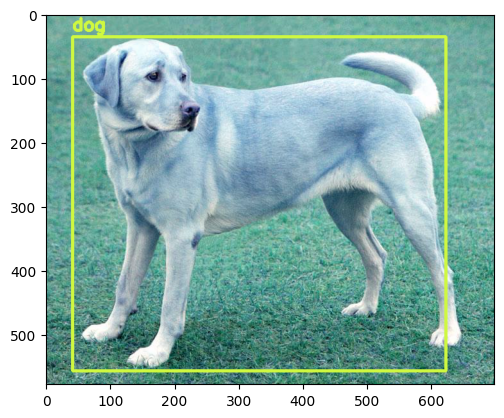

Video(value=b'\x00\x00\x01\xb0\x01\x00\x00\x01\xb5\x89\x13\x00\x00\x01\x00\x00\x00\x01 \x00\xc4\x8d\x88\x00\xc…

In [6]:
# this is output from fast_cnn not our model

from ipywidgets import Video, Image
input_path = 'dog.jpg'
output_path = 'dog_out.jpg'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)